In [1]:
import zipfile
import os, shutil
import collections
from pathlib import Path
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, concatenate
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
import pylab as pl
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import itertools
import math


# audio lib
import librosa
import librosa.display
from librosa.util import fix_length

import IPython.display as ipd
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
output_folder = "/kaggle/working/melspectrogram_tmp/"
os.mkdir(output_folder)

In [4]:
df = pd.read_csv('../input/my-playlist/my-playlist.csv', sep=';', dtype = str)


True_Label = df['Hidden_True_Label']

del df['Hidden_True_Label']

df = df.dropna()

df

,ID,Label1
4,Red Hot Chili Peppers - By The Way,3
5,Imagine Dragons - On Top of the World,3
7,Oasis - Wonderwall,1
9,Red Hot Chili Peppers - Snow,2
11,Sum 41 - The New Sensation,3
13,System Of A Down - Lonely Day,0
20,Green Day - Wake Me Up When September Ends,0
23,Nirvana - Smells Like Teen Spirit,2
25,Led Zeppelin - Stairway to Heaven,1


# Fine-Tuning

Si utilizzano le canzoni etichettate a mano per fare fine-tuning riaddestrando la rete ad imparare i gusti dell'utente. La rete utilizzerà come validation le stesse canzoni su cui farà training al fine di ottenere una sorta di "overfitting" sull'utente stesso, il quale desidera un modello che si sposti da una conoscenza generalizzata ad una "locale", basata sui propri gusti.

In [5]:
directory = '../input/my-playlist/Playlist/'

SAMPLE_RATE = 22050
TRACK_DURATION = 480
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

num_segments = 80
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)


num_mel = 96
n_fft = 2048
hop_length = 512

num_mel_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

Per ogni file musicale di cui è presente un'etichetta dell'utente si generano gli spettrogrammi corrispondenti a tutta la canzone. Ogni spettrogramma corrisponde ad un frame di 6 secondi.

In [6]:
# per ogni file musicale genero uno spectogramma
for filename in df['ID']:
    
    counter = 0
    
    print("Generando spettrogrammi da: "+filename)

    file_path = os.path.join(directory, filename+'.mp3')
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE,  offset=5.0, duration=TRACK_DURATION)
    
    counter_spectrogram = 0
    pic_array = []

    # genero spectogrammi per ogni 6 secondi di canzone
    for d in range(num_segments):
            
        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mel
        mel = librosa.feature.melspectrogram(y=signal[start:finish], sr=sample_rate, n_mels=num_mel, hop_length=hop_length)
        mel = mel.T


        if (len(mel) == num_mel_vectors_per_segment):

            # genero per ogni canzone 4 input per LSTM da 4 frame
            counter_spectrogram = counter_spectrogram + 1
            
            # creo una lista contenente i 4 spettrogrammi
            S_dB = librosa.power_to_db(mel.T)
            pic_array.append(S_dB)
            
            if counter_spectrogram == 4:
                # scorro i 4 spettrogrammi nella lista per generare le immagini 4 alla volta
                for i in range(4):
                    img_name = str(d-(3-i)) + '.png' # il contatore dell'immagine sarà dato da il valore di d - (3 - 1)
                    
                    new_filename = filename+'-'+img_name
                    
                    # genero le immagini da analizzare dalla CNN
                    fig = plt.figure(figsize=(3, 3), dpi=100)
                    img = librosa.display.specshow(pic_array[i])
                    plt.savefig("{}{}".format(output_folder, new_filename))
                    plt.close(fig)
                    
                # inizializzo i valori a 0 per il nuovo batch di 4 immagini    
                pic_array = []
                counter_spectrogram = 0



Generando spettrogrammi da: Red Hot Chili Peppers - By The Way
Generando spettrogrammi da: Imagine Dragons - On Top of the World
Generando spettrogrammi da: Oasis - Wonderwall
Generando spettrogrammi da: Red Hot Chili Peppers - Snow
Generando spettrogrammi da: Sum 41 - The New Sensation
Generando spettrogrammi da: System Of A Down - Lonely Day
Generando spettrogrammi da: Green Day - Wake Me Up When September Ends
Generando spettrogrammi da: Nirvana - Smells Like Teen Spirit
Generando spettrogrammi da: Led Zeppelin - Stairway to Heaven


Importo datasets originali al fine di effettuare il fine-tuning, unendo i dataset utilizzati in fase training origiale a quello ottenuto creando gli spettrogrammi delle canzoni etichettate dall'utente.

In [7]:
df1 = pd.read_csv('../input/mel-pmemo/mel.csv')
df2 = pd.read_csv('../input/mel-4q/mel.csv')
df3 = pd.read_csv('../input/mel-emotify/mel.csv')

df1['ID_song'] = df1['ID'].astype(str).str[0:4]
df2['ID_song'] = df2['ID'].astype(str).str[0:4]
df3['ID_song'] = df3['ID'].astype(str).str[0:4]

df1_ID = pd.DataFrame()
df1_ID['ID_song'] = df1['ID_song'].drop_duplicates()

df2_ID = pd.DataFrame()
df2_ID['ID_song'] = df2['ID_song'].drop_duplicates()

df3_ID = pd.DataFrame()
df3_ID['ID_song'] = df3['ID_song'].drop_duplicates()

df_ID = pd.concat([df1_ID[:150], df2_ID, df3_ID[:150]], ignore_index=True, sort=False)
df_merged = pd.concat([df1, df2, df3], ignore_index=True, sort=False)

print(df_ID.shape)
print(df_merged.shape)

for i in np.array(df_ID['ID_song']):
    miss = False
    
    if (i + '-0') not in df_merged['ID'].values:
        miss = True
    if (i + '-1') not in df_merged['ID'].values:
        miss = True
    if (i + '-2') not in df_merged['ID'].values:
        miss = True
    if (i + '-3') not in df_merged['ID'].values:
        miss = True
    if miss:
        df_ID = df_ID[df_ID.ID_song != i] # riga con solo un'immagine
        

ID_train, _ = train_test_split( np.array(df_ID['ID_song']), test_size=0.5, shuffle = True,  random_state=1)

print(ID_train.shape)

y_train_ID = []


for i in ID_train:
    if (i + '-0') in df_merged['ID'].values:
        y_train_ID.append(i + '-0')
    if (i + '-1') in df_merged['ID'].values:
        y_train_ID.append(i + '-1')
    if (i + '-2') in df_merged['ID'].values:
        y_train_ID.append(i + '-2')
    if (i + '-3') in df_merged['ID'].values:
        y_train_ID.append(i + '-3')


        
y_train_ID = np.array(y_train_ID)


print(y_train_ID.shape)



path1 = '../input/mel-pmemo/melspectrogram_dataset/'
path2 = '../input/mel-4q/melspectrogram_dataset/'
path3 = '../input/mel-emotify/melspectrogram_dataset/'


# Load the images and the labels
x_train = []
x_test = []
x_validation = []

for img in y_train_ID:
    if img[0] == '3':
        pic = image.load_img((path1 + img + '.png'))
        x_train.append(np.array(pic))
    elif img[0] == '1':
        pic = image.load_img((path2 + img + '.png'))
        x_train.append(np.array(pic))
    elif img[0] == '2':
        pic = image.load_img((path3 + img + '.png'))
        x_train.append(np.array(pic))

    
x_train_merged = np.array(x_train)

y_train = []

for i in ID_train:
    
    row = df_merged.loc[df_merged['ID'] == (i + '-0')]
    y_train.append(row['Label'].iloc[0])

    
    
    
y_train_merged = np.array(y_train)

print(y_train_merged.shape)

(1200, 1)
(9844, 3)
(596,)
(2384,)
(596,)


Per ogni canzone si generano blocchi da 4 spettrogrammi, al fine di mantenere la dimensione di input corretta per LSTM. I blocchi saranno di numero variabile in base alla lunghezza della canzone.

In [8]:
x_train = []
y_train = []

for song in df['ID']:
    print("Elaboro: "+song)
    contatore_immagini = 0
    esiste_immagine = True


    row = df.loc[df['ID'] == song]
    print("Label: "+row['Label1'].iloc[0])
     
    while esiste_immagine:
        
        pic = image.load_img(output_folder + song + '-' + str(contatore_immagini) + '.png')
        x_train.append(np.array(pic))
        esiste_immagine = os.path.exists(output_folder + song + '-' + str(contatore_immagini + 1) + '.png')
        contatore_immagini = contatore_immagini + 1
        
    for i in range(int((contatore_immagini) / 4)):
        y_train.append(row['Label1'].iloc[0])
    
    print("Numero di immagini generate: "+str(contatore_immagini))


x_train = np.array(x_train)
y_train = np.array(y_train, dtype = int)



print(x_train.shape)
print(y_train.shape)

x_test = x_train
y_test = y_train

Elaboro: Red Hot Chili Peppers - By The Way
Label: 3
Numero di immagini generate: 32
Elaboro: Imagine Dragons - On Top of the World
Label: 3
Numero di immagini generate: 28
Elaboro: Oasis - Wonderwall
Label: 1
Numero di immagini generate: 36
Elaboro: Red Hot Chili Peppers - Snow
Label: 2
Numero di immagini generate: 44
Elaboro: Sum 41 - The New Sensation
Label: 3
Numero di immagini generate: 36
Elaboro: System Of A Down - Lonely Day
Label: 0
Numero di immagini generate: 24
Elaboro: Green Day - Wake Me Up When September Ends
Label: 0
Numero di immagini generate: 44
Elaboro: Nirvana - Smells Like Teen Spirit
Label: 2
Numero di immagini generate: 44
Elaboro: Led Zeppelin - Stairway to Heaven
Label: 1
Numero di immagini generate: 76
(364, 300, 300, 3)
(91,)


Si concatenano i traning set e le labels dei datasets originali e quello ottenuto dall'utente.

In [9]:
x_train = np.concatenate((x_train, x_train_merged), axis=0)
y_train = np.concatenate((y_train, y_train_merged), axis=0)

Si importa la rete pre-addestrata CNN capace di riconoscere le features importanti in ogni spettrogramma.

In [10]:
base_net = load_model('../input/effnetb3spectrogram/weights.cnn.hdf5')
layer_name = 'flatten'
feature_extractor = Model(inputs=base_net.input, outputs=base_net.get_layer(layer_name).output)

2022-07-11 09:11:15.053179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 09:11:15.136779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 09:11:15.137604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 09:11:15.139342: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Da ogni spettrogramma si estraggono le features

In [11]:
feature_train = feature_extractor.predict(x_train, verbose=1)
print(feature_train.shape)

2022-07-11 09:11:20.657386: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 741960000 exceeds 10% of free system memory.
2022-07-11 09:11:21.441287: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 741960000 exceeds 10% of free system memory.
2022-07-11 09:11:22.001037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-11 09:11:23.851525: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


86/86 [==============================] - 10s 37ms/step
(2748, 1280)


Si mescolano i vari blocchi da 4 features al fine di non avere tutti i blocchi corrispondenti alla canzone consecutivi, così da favorire una migliore generalizzazione

In [12]:
reshaped_train = np.reshape(feature_train, (int(feature_train.shape[0] / 4), 4, -1))

x_train, y_train = shuffle(reshaped_train, y_train) # evito di avere tutte i frame consecutivi


print(reshaped_train.shape)

(687, 4, 1280)


Si ottengono le features corrispondenti solo agli spettrogrammi corrispettivi alle canzoni dell'utente, così da effettuare validation sulle stesse canzoni che si vogliono imparare a riconoscere

In [13]:
feature_test = feature_extractor.predict(x_test, verbose=1)
reshaped_test = np.reshape(feature_test, (int(feature_test.shape[0] / 4), 4, -1))
print(reshaped_test.shape)

12/12 [==============================] - 1s 52ms/step
(91, 4, 1280)


Si procede a importare il modello della rete LSTM.
La rete utilizza i seguenti iperparametri:


*   Tipo di modello: LSTM
*   Numero di epoche 50;
*   Activation Output Layer Softmax: funzione più usata per la classificazione multiclasse;
*   Activation Hidden Layer ReLU: è la funzione di "deafult" grazie alla sua versatilità per la maggior parte degli utilizzi;
*   Loss Function Sparse Categorical Crossentropy: funzione usata nella classificazione multiclasse usando varibili categoriche;
*   Optimizer RMSprop: funzione più utilizzata per le tipologie di rete ricorrenti. 
*   Al fine di effettuare fine-tuning si utilizza un learning rate molto piccolo (0.000001) così da variare poco i pesi originali ad ogni aggiornamento
*   Regolarizzazione tramite dropout.
*   Per creare un modello che conosca al meglio le emozioni dell'utente si utilizzano i pesi che hanno ottenuto lo score migliore sul validation set.



In [14]:
LSTM = load_model('../input/lstmspectrogram/weights.cnn.hdf5')

filepath_LSTM="./weights.LSTM.hdf5"
checkpoint = ModelCheckpoint(filepath_LSTM, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

tf.keras.optimizers.RMSprop(learning_rate=0.000001)
    
LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])


history = LSTM.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(reshaped_test, y_test), callbacks=[checkpoint])
LSTM.load_weights(filepath_LSTM)

Epoch 1/50
22/22 [==============================] - 3s 37ms/step - loss: 2.4717 - accuracy: 0.8020 - val_loss: 6.4429 - val_accuracy: 0.4396

Epoch 00001: val_accuracy improved from -inf to 0.43956, saving model to ./weights.LSTM.hdf5
Epoch 2/50
22/22 [==============================] - 1s 23ms/step - loss: 1.8338 - accuracy: 0.8253 - val_loss: 5.1023 - val_accuracy: 0.4835

Epoch 00002: val_accuracy improved from 0.43956 to 0.48352, saving model to ./weights.LSTM.hdf5
Epoch 3/50
22/22 [==============================] - 1s 24ms/step - loss: 1.0993 - accuracy: 0.8428 - val_loss: 4.1180 - val_accuracy: 0.5165

Epoch 00003: val_accuracy improved from 0.48352 to 0.51648, saving model to ./weights.LSTM.hdf5
Epoch 4/50
22/22 [==============================] - 1s 25ms/step - loss: 1.2123 - accuracy: 0.8486 - val_loss: 2.5962 - val_accuracy: 0.5934

Epoch 00004: val_accuracy improved from 0.51648 to 0.59341, saving model to ./weights.LSTM.hdf5
Epoch 5/50
22/22 [==============================] -

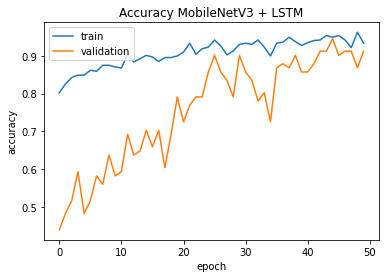

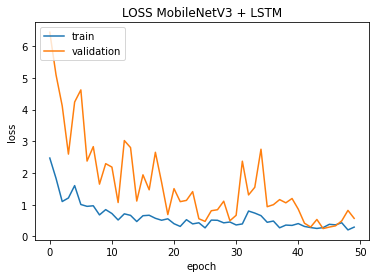

In [15]:
def plot_hist(hist, title):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Accuracy " + title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


plot_hist(history, title="MobileNetV3 + LSTM")

Ovviamente si raggiungono risultati molto alti dovuti all'overfitting causato dal riutilizzo dei dati di training nel validation set, ma ciò è voluto per creare fine-tuning sull'utente.

# Verifica classificazione su playlist

Si utilizza il nuovo modello su tutta la playlist, così da verificare che esso sia più in linea con le emozioni dell'utente.

In [16]:
# cancello la directory temporanea e la ricero
shutil.rmtree(output_folder)
os.mkdir(output_folder)

In [17]:
data = {
    'ID' : [],
    'A-V-' : [],
    'A-V+' : [],
    'A+V-' : [],
    'A+V+' : []
}

directory = '../input/my-playlist/Playlist/'

SAMPLE_RATE = 22050
TRACK_DURATION = 480
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

num_segments = 80
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)


num_mel = 96
n_fft = 2048
hop_length = 512

num_mel_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

In [18]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [19]:
print("Classificazione mood canzioni in corso...")
print("Legenda:")
print("0: basso Arousal - basso valence ")
print("1: basso Arousal - alto valence ")
print("2: alto Arousal - basso valence ")
print("3: alto Arousal - alto valence ")
print("----------------------------------------------------")

# per ogni file musicale genero uno spectogramma temporaneo
for filename in os.listdir(directory):
    labels = []
    
    filename_no_extension = Path(filename).stem
    data["ID"].append(filename_no_extension)
    
    file_path = os.path.join(directory, filename)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE,  offset=5.0, duration=TRACK_DURATION)

    # genero spectogrammi per ogni 6 secondi di canzone
    for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mel
                    mel = librosa.feature.melspectrogram(y=signal[start:finish], sr=sample_rate, n_mels=num_mel, hop_length=hop_length)
                    mel = mel.T

                    
                    if (len(mel) == num_mel_vectors_per_segment):
                        
                        
                        img_name = str(d) + '.png'

                        


                        fig = plt.figure(figsize=(3, 3), dpi=100)
                        S_dB = librosa.power_to_db(mel.T)
                        img = librosa.display.specshow(S_dB)
                        
                        plt.savefig("{}{}".format(output_folder,img_name))
                        plt.close(fig)

    # per ogni 4 spettrogrammi generati dalla canzone eseguo la predizione e creo una lista con tutte le predizioni riferite ad una canzone
    counter_spectrogram = 0
    pic_array = []
    features_spectrogram = []
    
    dir_spectogram = sorted_alphanumeric(os.listdir(output_folder))
    for i in dir_spectogram:
        
        counter_spectrogram = counter_spectrogram + 1 # incremento il contatore di frame

        # ottengo le features
        file_path = os.path.join(output_folder, i)
        pic = image.load_img(file_path)
        pic = np.array(pic)
        pic_array.append(pic)

            
        if counter_spectrogram == 4:
            pic_array = np.array(pic_array)
            features_spectrogram = feature_extractor.predict(pic_array)
            features_spectrogram = np.reshape(features_spectrogram, (1, 4, -1))
            classification = LSTM.predict(features_spectrogram)
            labels.append(np.argmax(classification))
            
            counter_spectrogram = 0
            pic_array = []
            features_spectrogram = []
    
    
    # creo una lista con le percentuali di mood per ogni canzone

    counter = collections.Counter(labels)
    most_common= [(i, round(counter[i] / len(labels) * 100.0, 1)) for i, count in counter.most_common()]
    
    # trasformo la lista in campi per il dataframe
    i0 = False
    i1 = False
    i2 = False
    i3 = False
    
    for i in range(len(most_common)):
        if most_common[i][0] == 0:
            i0 = True
            data['A-V-'].append(most_common[i][1])
        elif most_common[i][0] == 1:
            i1 = True
            data['A-V+'].append(most_common[i][1])
        elif most_common[i][0] == 2:
            i2 = True
            data['A+V-'].append(most_common[i][1])
        elif most_common[i][0] == 3:
            i3 = True
            data['A+V+'].append(most_common[i][1])
            
    
    if not(i0):
        data['A-V-'].append(0)
    if not(i1):
        data['A-V+'].append(0)
    if not(i2):
        data['A+V-'].append(0)
    if not(i3):
        data['A+V+'].append(0)

            
        
    

    print("File: "+filename)
    print("Predizioni:")
    print(labels)
    print("Mood in percentuale: "+ str(most_common))    
    print("----------------------------------------------------")
    
    # cancello la directory temporanea e la ricero
    shutil.rmtree(output_folder)
    os.mkdir(output_folder)

Classificazione mood canzioni in corso...
Legenda:
0: basso Arousal - basso valence 
1: basso Arousal - alto valence 
2: alto Arousal - basso valence 
3: alto Arousal - alto valence 
----------------------------------------------------
File: Fabrizio De Andr - La canzone di Marinella.mp3
Predizioni:
[1, 1, 1, 1, 0, 1, 1]
Mood in percentuale: [(1, 85.7), (0, 14.3)]
----------------------------------------------------
File: John Coltrane - Naima.mp3
Predizioni:
[0, 0, 0, 1, 1, 1, 1, 1, 1, 0]
Mood in percentuale: [(1, 60.0), (0, 40.0)]
----------------------------------------------------
File: Nirvana - Come As You Are.mp3
Predizioni:
[0, 3, 3, 3, 2, 2, 0, 2, 0]
Mood in percentuale: [(0, 33.3), (3, 33.3), (2, 33.3)]
----------------------------------------------------
File: Queen - Radio Ga Ga.mp3
Predizioni:
[2, 0, 1, 3, 3, 3, 2, 3, 3, 3, 2, 1, 3, 1]
Mood in percentuale: [(3, 50.0), (2, 21.4), (1, 21.4), (0, 7.1)]
----------------------------------------------------
File: Red Hot Chili P

Una volta ottenute le varie inferenze sulle canzoni vengono confrontati i valori reali e quelli ottenuti dal modello.

In [20]:
df = pd.DataFrame(data)

for index,row in df.iterrows():
    if row[1] >= row[2] and row[1] >= row[3] and row[1] >= row[4]:
        df.loc[index,'Max_Overall_Emotion'] = '0'
    elif row[2] >= row[3] and row[2] >= row[4]:
        df.loc[index,'Max_Overall_Emotion'] = '1'
    elif row[3] >= row[4]:
        df.loc[index,'Max_Overall_Emotion'] = '2'
    else:
        df.loc[index,'Max_Overall_Emotion'] = '3'
        
df['True_Emotion'] = True_Label

for index,row in df.iterrows():
    if row[5] == row[6]:
        df.loc[index,'Wrong_Inferences'] = False
    else: # la predizione è corretta se il valore predetto è uguale al valore originale
        if row[(int(row[6])+1)] - row[(int(row[5])+1)] == 0: 
            df.loc[index,'Wrong_Inferences'] = False
        else:
            df.loc[index,'Wrong_Inferences'] = True
        
    df.loc[index, 'diff_abs'] = abs(row[(int(row[6])+1)] - row[(int(row[5])+1)])
        

df.to_csv('finetuned.csv',index=False)

df

,ID,A-V-,A-V+,A+V-,A+V+,Max_Overall_Emotion,True_Emotion,Wrong_Inferences,diff_abs
0,Fabrizio De Andr - La canzone di Marinella,14.3,85.7,0.0,0.0,1,0,True,71.4
1,John Coltrane - Naima,40.0,60.0,0.0,0.0,1,1,False,0.0
2,Nirvana - Come As You Are,33.3,0.0,33.3,33.3,0,2,False,0.0
3,Queen - Radio Ga Ga,7.1,21.4,21.4,50.0,3,3,False,0.0
4,Red Hot Chili Peppers - By The Way,0.0,0.0,0.0,100.0,3,3,False,0.0
5,Imagine Dragons - On Top of the World,0.0,0.0,0.0,100.0,3,3,False,0.0
6,Green Day - Time of Your Life,33.3,33.3,16.7,16.7,0,0,False,0.0
7,Oasis - Wonderwall,0.0,88.9,0.0,11.1,1,1,False,0.0
8,Eagles - Hotel California,18.8,43.8,6.2,31.2,1,1,False,0.0
9,Red Hot Chili Peppers - Snow,0.0,0.0,90.9,9.1,2,2,False,0.0


In [21]:
print("Errori di classificazione:")
for index,row in df.iterrows():
    if row[7]:
        print("Canzone: "+row[0])
        print("Emozione vera: " +row[6])
        print("Emozione trovata: " +row[5])
        print("Valore stimato emozione vera: "+str(row[(int(row[6])+1)]))
        print("Valore stimato emozione trovata: "+str(row[(int(row[5])+1)]))
        print("Differenza in valore assoluto: {:.2f}".format(row[8]))
        print("------------------------------------------------")

Errori di classificazione:
Canzone: Fabrizio De Andr - La canzone di Marinella
Emozione vera: 0
Emozione trovata: 1
Valore stimato emozione vera: 14.3
Valore stimato emozione trovata: 85.7
Differenza in valore assoluto: 71.40
------------------------------------------------
Canzone: Caparezza - Vengo dalla Luna
Emozione vera: 2
Emozione trovata: 3
Valore stimato emozione vera: 40.0
Valore stimato emozione trovata: 60.0
Differenza in valore assoluto: 20.00
------------------------------------------------
Canzone: Fabrizio De Andr - Il Testamento di Tito
Emozione vera: 0
Emozione trovata: 1
Valore stimato emozione vera: 0.0
Valore stimato emozione trovata: 100.0
Differenza in valore assoluto: 100.00
------------------------------------------------
Canzone: System Of A Down - B.Y.O.B.
Emozione vera: 2
Emozione trovata: 3
Valore stimato emozione vera: 40.0
Valore stimato emozione trovata: 60.0
Differenza in valore assoluto: 20.00
------------------------------------------------
Canzone: So

In [22]:
print("Numero canzoni corrette: " + str(df.Wrong_Inferences.value_counts()[0]))
print("Numero canzoni errate: " + str(df.Wrong_Inferences.value_counts()[1]))
print("Differenza media predizione errate: {:.2f}".format(df[df.Wrong_Inferences == True].diff_abs.mean()))

Numero canzoni corrette: 36
Numero canzoni errate: 14
Differenza media predizione errate: 34.92
